In [1]:
# import packages
import numpy as np
from wrf import getvar, disable_xarray
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime 
from dateutil.rrule import rrule, HOURLY
import master_functions as mf
from scipy import stats
from mask_tc_track_3d import mask_tc_track_3d

In [2]:
nmem = 10
membs = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']

In [3]:
c_type_ctl = mf.var_read('/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/cloud_class/precip_class_ctl.nc', 'type') # memb x time x lat x lon
print('ctl')
c_type_ncrf = mf.var_read('/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/cloud_class/precip_class_ncrf36h.nc', 'type') # memb x time x lat x lon
print('ncrf')
c_type_saoff = mf.var_read('/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/cloud_class/precip_class_STRATANVIL_OFF.nc', 'type') # memb x time x lat x lon
print('saoff')
c_type_saon = mf.var_read('/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/cloud_class/precip_class_STRATANVIL_ON.nc', 'type') # memb x time x lat x lon
print('saon')
c_type_soff = mf.var_read('/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/cloud_class/precip_class_STRAT_OFF.nc', 'type') # memb x time x lat x lon

ctl
ncrf
saoff
saon


In [4]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    # n = len(a)
    n = a.shape[0]
    m, se = np.mean(a, axis=1), stats.sem(a, axis=1) # specifically for type x mem x time
    num = stats.t.ppf((1 + confidence) / 2., n-1)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h
conf_set=0.95 # Confidence interval to apply throughout

In [5]:
def cloud_fraction(data, type):
    if type == 0:
        ind = np.ma.masked_where((data == type), data)
    else:
        ind = np.ma.masked_where((data != type), data)
    count_total = np.ma.count(data, axis=(2,3)) # for 4-D array (mem x time x lat x lon)
    type_count = np.ma.MaskedArray.count(ind, axis=(2,3)) # for 4-D array (mem x time x lat x lon)
    fraction = type_count/count_total
    return fraction

In [6]:
type_list = ['Deep Convective', 'Congestus', 'Shallow Convective', 'Stratiform', 'Anvil', 'Total']

In [7]:
frac_ctl = np.empty((len(type_list), nmem, 97)) # type x mem x time
frac_ncrf = np.empty((len(type_list), nmem, 49)) # type x mem x time
frac_saoff = np.empty((len(type_list), nmem, 49)) # type x mem x time
frac_saon = np.empty((len(type_list), nmem, 49)) # type x mem x time
frac_soff = np.empty((len(type_list), nmem, 49)) # type x mem x time

for t in range(6):
    frac_ctl[t,:,:] = cloud_fraction(c_type_ctl, t)
    frac_ncrf[t,:,:] = cloud_fraction(c_type_ncrf, t)
    frac_saoff[t,:,:] = cloud_fraction(c_type_saoff, t)
    frac_saon[t,:,:] = cloud_fraction(c_type_saon, t)
    frac_soff[t,:,:] = cloud_fraction(c_type_soff, t)

In [8]:
m_ctl, low_ctl, high_ctl = mean_confidence_interval(frac_ctl[:,:,:])
m_ncrf, low_ncrf, high_ncrf = mean_confidence_interval(frac_ncrf[:,:,:]) 
m_saoff, low_saoff, high_saoff = mean_confidence_interval(frac_saoff[:,:,:]) 
m_saon, low_saon, high_saon = mean_confidence_interval(frac_saon[:,:,:]) 
m_soff, low_soff, high_soff = mean_confidence_interval(frac_soff[:,:,:]) 

In [9]:
time = np.arange(0,97,1)

In [10]:
# universal plotting parameters
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)

In [11]:
m_ctlp = m_ctl*100
m_ncrfp = m_ncrf*100
m_saonp = m_saon*100
m_saoffp = m_saoff*100
m_soffp = m_soff*100

low_ctlp = low_ctl*100
low_ncrfp = low_ncrf*100

high_ctlp = high_ctl*100
high_ncrfp = high_ncrf*100

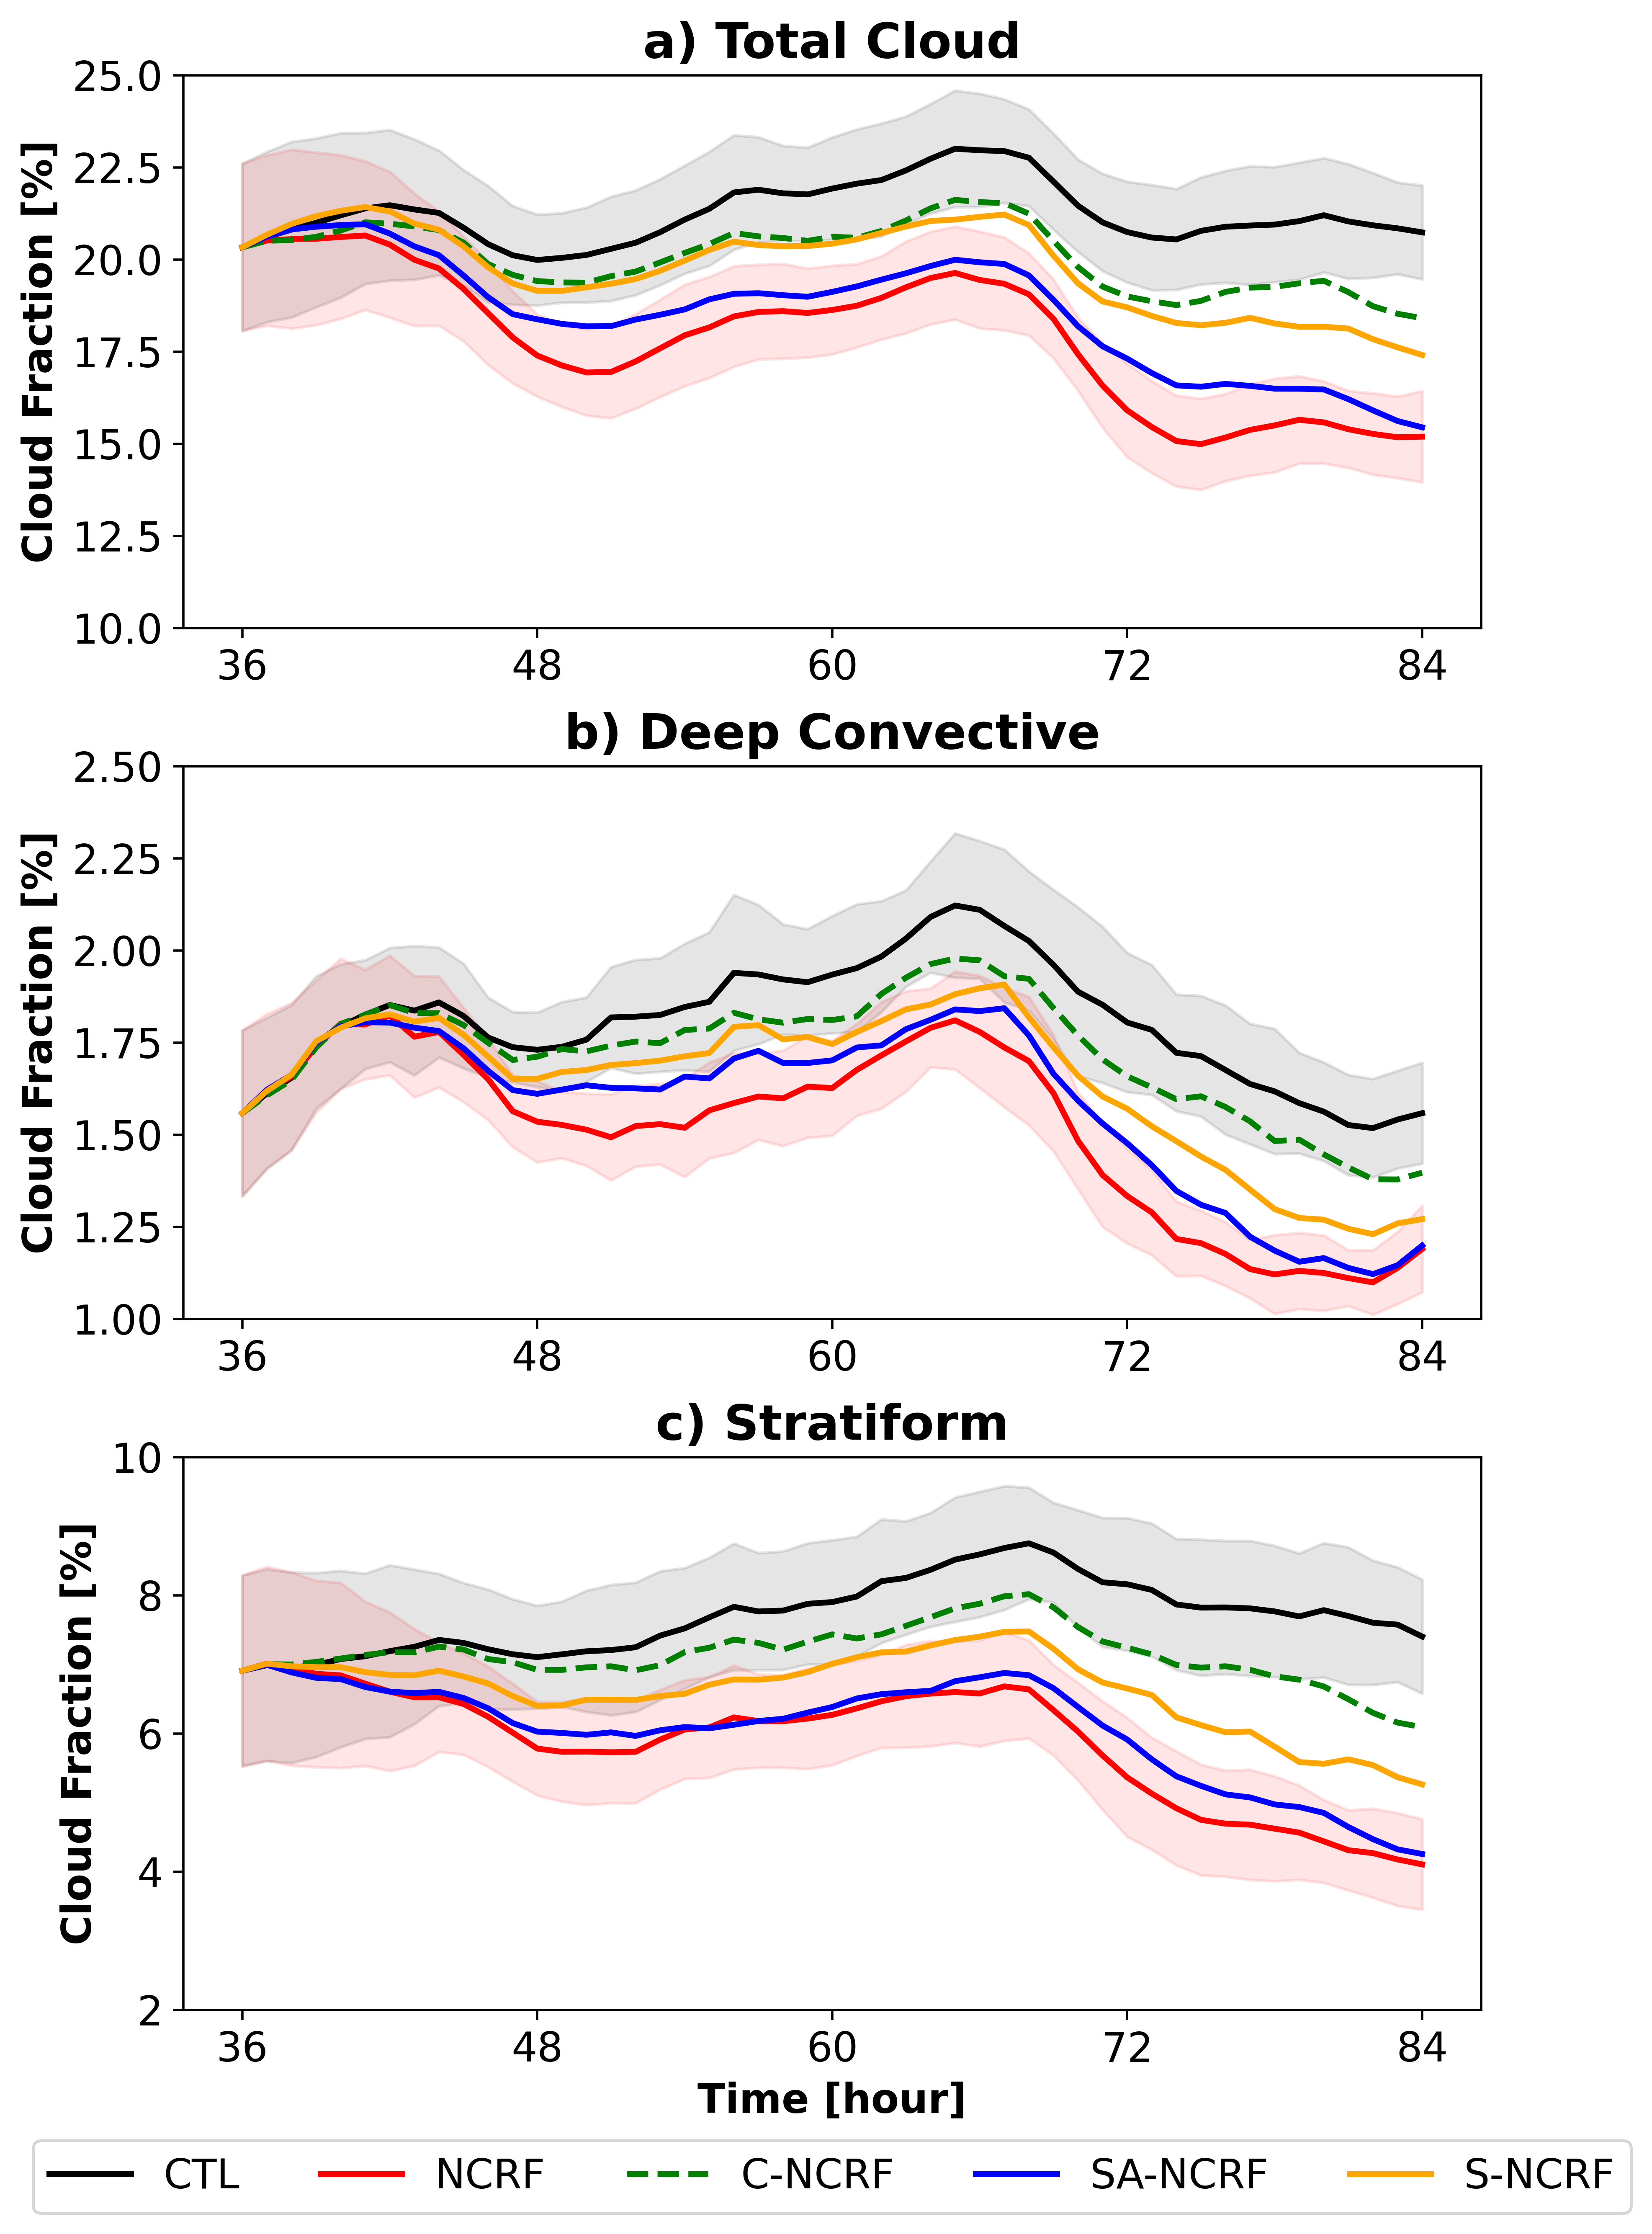

In [12]:
a = 0.1
lw = 2
fig = plt.figure(figsize=(8,12), dpi=500)
ax = fig.add_subplot(312)
ax.plot(time[36:85], m_ctlp[1,36:85], color='black', label='CTL', linewidth=lw)
ax.fill_between(time[36:85], low_ctlp[1,36:85], high_ctlp[1,36:85], alpha=a, color='black')
ax.plot(time[36:85], m_ncrfp[1], color='red', label='NCRF', linewidth=lw) 
ax.fill_between(time[36:85], low_ncrfp[1], high_ncrfp[1], alpha=a, color='red')
ax.plot(time[36:85],m_saonp[1], color='green', linestyle='--',label='C-NCRF', linewidth=lw)
ax.plot(time[36:85],m_saoffp[1], color='blue', label='SA-NCRF', linewidth=lw)
ax.plot(time[36:85],m_soffp[1], color='orange', label='S-NCRF', linewidth=lw)
t_ticks = np.arange(36, 85, 12)
ax.set_xticks(t_ticks)
ax.set_ylim(1,2.5)
ax.set_ylabel('Cloud Fraction [%]', weight='bold')
ax.set_title('b) Deep Convective', weight='bold')

ax = fig.add_subplot(313)
ax.plot(time[36:85], m_ctlp[4,36:85], color='black', label='CTL', linewidth=lw)
ax.fill_between(time[36:85], low_ctlp[4,36:85], high_ctlp[4,36:85], alpha=a, color='black')
ax.plot(time[36:85], m_ncrfp[4], color='red', label='NCRF', linewidth=lw) 
ax.fill_between(time[36:85], low_ncrfp[4], high_ncrfp[4], alpha=a, color='red')
ax.plot(time[36:85],m_saonp[4], color='green', linestyle='--',label='C-NCRF', linewidth=lw)
ax.plot(time[36:85],m_saoffp[4], color='blue', label='SA-NCRF', linewidth=lw)
ax.plot(time[36:85],m_soffp[4], color='orange', label='S-NCRF', linewidth=lw)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, ncol=5)
t_ticks = np.arange(36, 85, 12)
ax.set_xticks(t_ticks)
ax.set_ylim(2,10)
ax.set_ylabel('Cloud Fraction [%]', weight='bold')
ax.set_xlabel('Time [hour]', weight='bold')
ax.set_title('c) Stratiform', weight='bold')

ax = fig.add_subplot(311)
ax.plot(time[36:85], m_ctlp[0,36:85], color='black', label='CTL', linewidth=lw)
ax.fill_between(time[36:85], low_ctlp[0,36:85], high_ctlp[0,36:85], alpha=a, color='black')
ax.plot(time[36:85], m_ncrfp[0], color='red', label='NCRF', linewidth=lw) 
ax.fill_between(time[36:85], low_ncrfp[0], high_ncrfp[0], alpha=a, color='red')
ax.plot(time[36:85],m_saonp[0], color='green', linestyle='--',label='C-NCRF', linewidth=lw)
ax.plot(time[36:85],m_saoffp[0], color='blue', label='SA-NCRF', linewidth=lw)
ax.plot(time[36:85],m_soffp[0], color='orange', label='S-NCRF', linewidth=lw)
t_ticks = np.arange(36, 85, 12)
ax.set_xticks(t_ticks)
ax.set_ylim(10, 25)
ax.set_ylabel('Cloud Fraction [%]', weight='bold')
ax.set_title('a) Total Cloud', weight='bold')

plt.subplots_adjust(wspace=0.2, hspace=0.25)

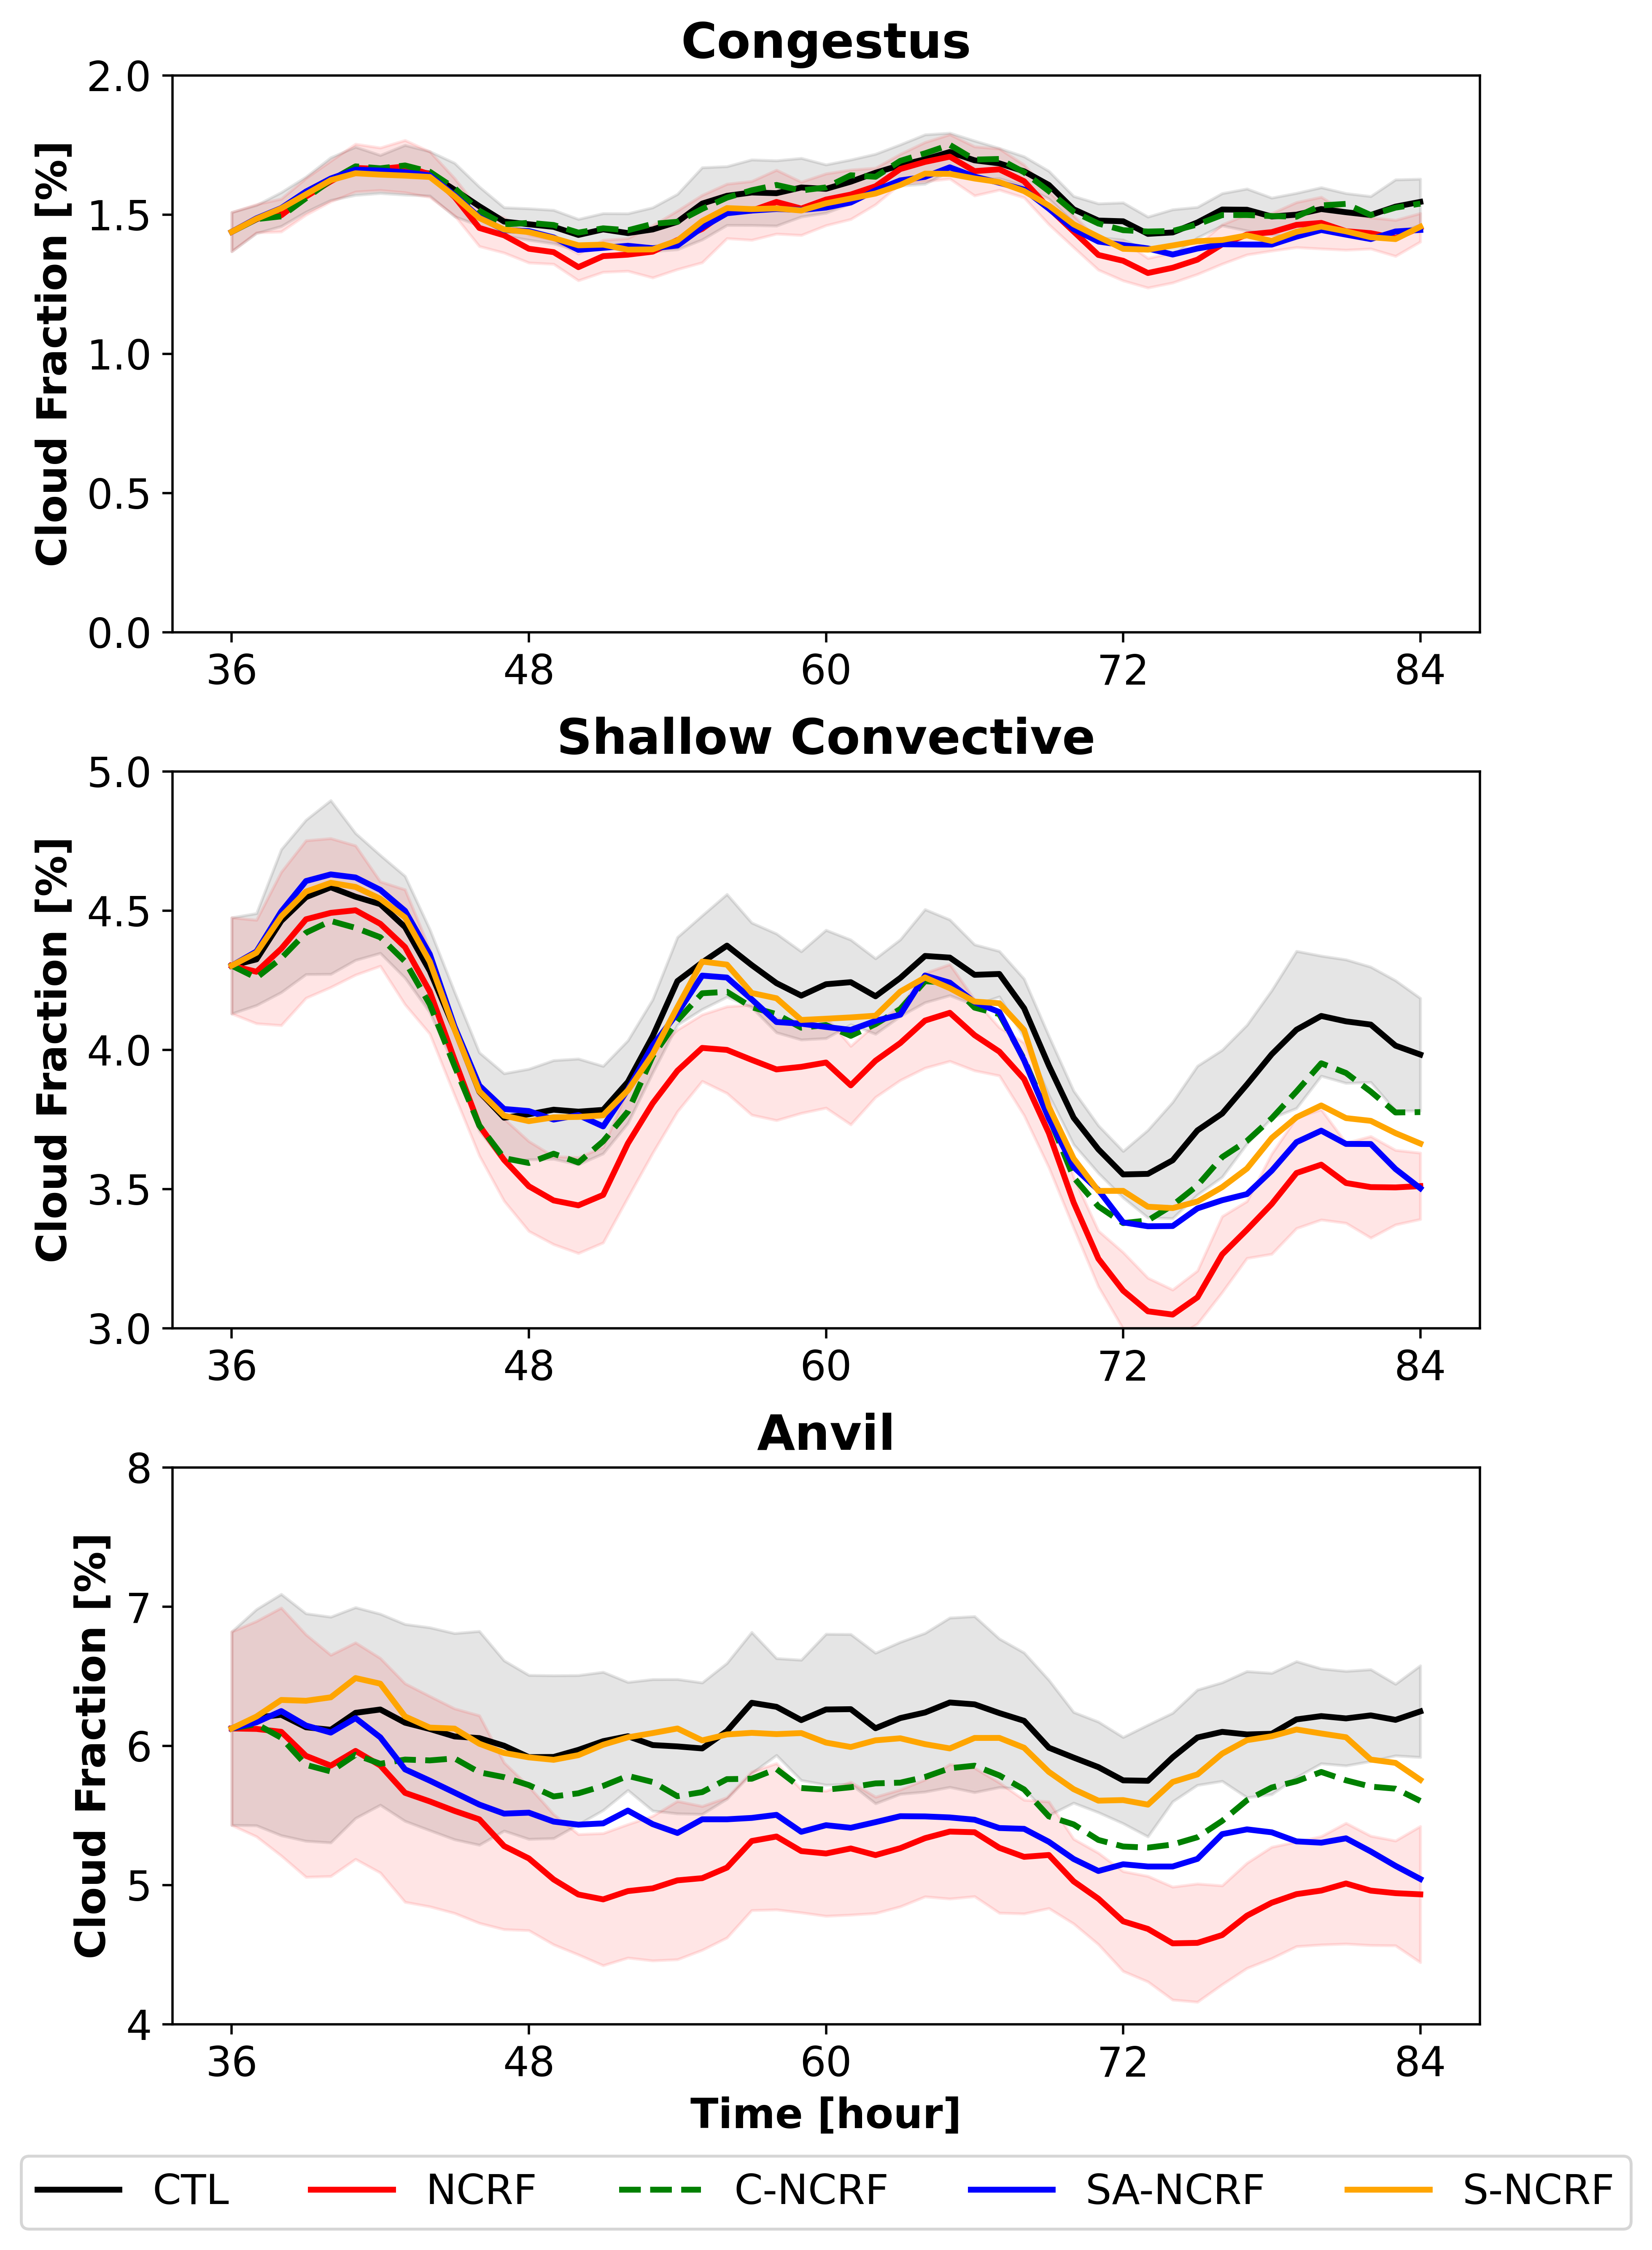

In [72]:
a = 0.1
lw = 2
fig = plt.figure(figsize=(8,12),facecolor='white', dpi=500)
ax = fig.add_subplot(311)
ax.plot(time[36:85], m_ctlp[2,36:85], color='black', label='CTL', linewidth=lw)
ax.fill_between(time[36:85], low_ctlp[2,36:85], high_ctlp[2,36:85], alpha=a, color='black')
ax.plot(time[36:85], m_ncrfp[2], color='red', label='NCRF', linewidth=lw) 
ax.fill_between(time[36:85], low_ncrfp[2], high_ncrfp[2], alpha=a, color='red')
ax.plot(time[36:85],m_saonp[2], color='green', linestyle='--',label='C-NCRF', linewidth=lw)
ax.plot(time[36:85],m_saoffp[2], color='blue', label='SA-NCRF', linewidth=lw)
ax.plot(time[36:85],m_soffp[2], color='orange', label='S-NCRF', linewidth=lw)
t_ticks = np.arange(36, 85, 12)
ax.set_xticks(t_ticks)
ax.set_ylim(0,2)
ax.set_ylabel('Cloud Fraction [%]', weight='bold')
ax.set_title('Congestus', weight='bold')

ax = fig.add_subplot(312)
ax.plot(time[36:85], m_ctlp[3,36:85], color='black', label='CTL', linewidth=lw)
ax.fill_between(time[36:85], low_ctlp[3,36:85], high_ctlp[3,36:85], alpha=a, color='black')
ax.plot(time[36:85], m_ncrfp[3], color='red', label='NCRF', linewidth=lw) 
ax.fill_between(time[36:85], low_ncrfp[3], high_ncrfp[3], alpha=a, color='red')
ax.plot(time[36:85],m_saonp[3], color='green', linestyle='--',label='C-NCRF', linewidth=lw)
ax.plot(time[36:85],m_saoffp[3], color='blue', label='SA-NCRF', linewidth=lw)
ax.plot(time[36:85],m_soffp[3], color='orange', label='S-NCRF', linewidth=lw)
t_ticks = np.arange(36, 85, 12)
ax.set_xticks(t_ticks)
ax.set_ylim(3,5)
ax.set_ylabel('Cloud Fraction [%]', weight='bold')
ax.set_title('Shallow Convective', weight='bold')

ax = fig.add_subplot(313)
ax.plot(time[36:85], m_ctlp[5,36:85], color='black', label='CTL', linewidth=lw)
ax.fill_between(time[36:85], low_ctlp[5,36:85], high_ctlp[5,36:85], alpha=a, color='black')
ax.plot(time[36:85], m_ncrfp[5], color='red', label='NCRF', linewidth=lw) 
ax.fill_between(time[36:85], low_ncrfp[5], high_ncrfp[5], alpha=a, color='red')
ax.plot(time[36:85],m_saonp[5], color='green', linestyle='--',label='C-NCRF', linewidth=lw)
ax.plot(time[36:85],m_saoffp[5], color='blue', label='SA-NCRF', linewidth=lw)
ax.plot(time[36:85],m_soffp[5], color='orange', label='S-NCRF', linewidth=lw)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, ncol=5)
t_ticks = np.arange(36, 85, 12)
ax.set_xticks(t_ticks)
ax.set_ylim(4, 8)
ax.set_ylabel('Cloud Fraction [%]', weight='bold')
ax.set_xlabel('Time [hour]', weight='bold')
ax.set_title('Anvil', weight='bold')

plt.subplots_adjust(wspace=0.2, hspace=0.25)